In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import preprocessing
from itertools import product
from scipy import interpolate, stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [2]:
%matplotlib inline
# inline 

In [190]:
data = pd.read_csv(r"C:\Users\Edwin\Downloads\test_df")
data = data.drop(data.index[0]) # drop dumb header
# data = data[data['400.0nm'] < 0.2]
# data = data[data['400.0nm'] > 0.05]
# data = data.iloc[::3]

In [191]:
# pull data
pfh = np.asarray(pd.to_numeric(data['Component 3 wtf'] , errors='coerce')[1:-1])
ethanol = np.asarray(pd.to_numeric(data['Component 4 wtf'] , errors='coerce')[1:-1])
absorbance = np.asarray(pd.to_numeric(data['400.0nm'] , errors='coerce')[1:-1])


In [192]:
# scaling/normalizing and standardizing, sklearn requires a (number_of_samples, number_of_features) shape
# it will do the appropiate operation to each column (feature) using the data of each individual row (sample point)
# the only issue with wrapping all columns in one is that if you want to use for say 2/3 it wont work

In [193]:
# collected data and standardization/scaling/normalization # 

x1 = ethanol #np.array([-8.0, -6.00, -7.0, -4.0, 2.0, 5.0, 1.0, 3.0, 7.0])
x2 = pfh #np.array([-8.0, -3.0, 2.0, 4.0, 3.0, 7.0, -1.0, -4.0, -7.0])
y_data = absorbance #np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0])

x1_transformed = x1[:, np.newaxis]
scalerx1 = preprocessing.RobustScaler().fit(x1_transformed) #not a huge diff between robustscalar and standardscalar
x1_scaled = scalerx1.transform(x1_transformed)

x2_transformed = x2[:, np.newaxis]
scalerx2 = preprocessing.RobustScaler().fit(x2_transformed)
x2_scaled = scalerx2.transform(x2_transformed)

y_transformed = y_data[:, np.newaxis]
scalery = preprocessing.RobustScaler().fit(y_transformed)
y_scaled = scalery.transform(y_transformed)

# all_data = np.array([x1,x2,y_data]).T
# scalar = preprocessing.StandardScaler().fit(all_data)
# all_data_scaled = scalar.transform(all_data)

x1 = x1_scaled[:,0]
x2 = x2_scaled[:,0]
x1x2 = np.asarray([x1,x2]).T
y_data = y_scaled[:,0]

x1_min = min(x1) - min(x1)*0.2
x1_max = max(x1) + max(x1)*0.2

x2_min = min(x2) - min(x2)*0.2
x2_max = max(x2) + max(x2)*0.2 # make is o max wont exceed 1 

y_min = min(y_data)
y_max = max(y_data)

In [194]:
kernal = C(1, (1e-1, 1e3)) * RBF(1, (1e-3, 1e3)) 
gp_model = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=20,alpha=0.07, normalize_y=True) # random_state=42
gp_model.fit(x1x2, y_data)
# y_prior = gp_model.predict(x1x2t)
# y_prior # should the prior be solely zerp

GaussianProcessRegressor(alpha=0.07, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, normalize_y=True)

In [211]:
# test data to make mesh a
x1t = np.linspace(x1_min,x1_max,100) #np.arange(x1_min,x1_max,0.1) # need to automate resolution, but if not use lispace
x2t = np.linspace(x2_min,x2_max,100) #np.arange(x2_min,x2_max,0.1)

d1 = x1t.shape[0] 
d2 = x2t.shape[0]

x1x2t_ = np.array(list(product(x1t, x2t))) # just to make points in the frame and size of mesh
scalerx1x2 = preprocessing.StandardScaler().fit(x1x2) # according to test or training? THIS HELPS BUT NEED TO EXPLAIN WHY AND ALSO MIGHT BE OKAY TO FOREGO?
x1x2t = scalerx1x2.transform(x1x2t_)

# why does this not produce the same results
# x1t_transformed = scalerx1.transform(x1x2t[:,0][:, np.newaxis])
# x2t_transformed = scalerx2.transform(x1x2t[:,1][:, np.newaxis])
# x1x2t_transformed = np.asarray([x1t_transformed, x2t_transformed]).T

In [212]:
# figure out how to reconvert to original

In [213]:
# x1x2t= np.array(list(product(x1t, x2t))) # just to make points in the frame and size of mesh
# print(x1x2t[0])
# scalerx1x2 = preprocessing.RobustScaler().fit(x1x2) # this is only necessary as when doing a product leads to bleh, the x1x2 is just compacted togetehr making it easier, could do x1 and x2 seperately
# x1x2t = scalerx1x2.transform(x1x2t)
# print(x1x2t[0])
# x1x2t = scalerx1x2.inverse_transform(x1x2t)
# print(x1x2t[0])
# scalerx1.inverse_transform(x1t[:, np.newaxis])[0:5], ethanol[0:5]

In [214]:
# Compute prediction and revert back to cart coord, but would need to do the same for the min and max for the things
y_pred, MSE = gp_model.predict(x1x2t, return_std=True) 

# x1x2t = scalerx1x2.inverse_transform(x1x2t)
y_pred = scalery.inverse_transform(y_pred[:, np.newaxis]) # so this works fine, but what about x1 and x2 mesh

x1t_m = x1x2t[:,0]#scalerx1.inverse_transform(x1x2t[:,0][:, np.newaxis])
x2t_m = x1x2t[:,1]#scalerx2.inverse_transform(x1x2t[:,1][:, np.newaxis])

X1 = x1t_m.reshape(d2,d1) # reshape is essential to make (n,2) to (n,n)
X2 = x2t_m.reshape(d2,d1)
Y = np.reshape(y_pred,(d2,d1))

In [221]:
x1t_m

array([-1.88733271, -1.88733271, -1.88733271, ...,  1.6304639 ,
        1.6304639 ,  1.6304639 ])

In [215]:
%matplotlib inline

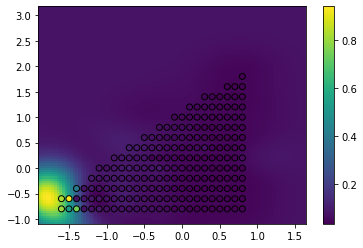

In [216]:
fig, ax = plt.subplots(1)
norm =colors.Normalize(vmin=y_min,vmax=y_max) # is this normalization correct?
mappable = ax.pcolormesh(X1,X2,Y, shading = 'auto')
fig.colorbar(mappable)
plt.scatter(x1,x2,norm=norm,c=y_data,edgecolors='k')
plt.show()

Text(0.5, 0, 'AU')

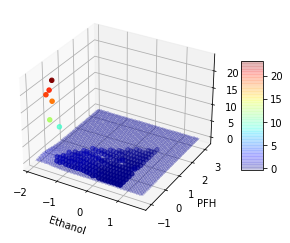

In [222]:
# make sure nornmailzing color bar appr
# NOTE: vmin/vmax supercedes norm, vmin/vmax input is defaulted to colors.Normalize linear normazilation
# %matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
norm =colors.Normalize(vmin=y_min,vmax=y_max)
ax.scatter(x1,x2,y_data,c=y_data, norm=norm, cmap='jet')
surf = ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Ethanol')
ax.set_ylabel('PFH')
ax.set_zlabel('AU')

In [209]:
"""why is infinately going in the same color in one direction? is it because the sampling is not 
cubic as in its weighing in one direction? It seems to only be modeling in one direction rather than two?
But this seems to be an artifact of the data and not the modeling since test data works fine, but that is sparse 

I wonder if data is just random if it will just make that same gradient"""

'why is infinately going in the same color in one direction? is it because the sampling is not \ncubic as in its weighing in one direction? It seems to only be modeling in one direction rather than two?\nBut this seems to be an artifact of the data and not the modeling since test data works fine, but that is sparse \n\nI wonder if data is just random if it will just make that same gradient'

In [ ]:
# TESTING
%matplotlib qt
# so the way it goes is the vmin/vmax can go in either in the norm or the direct plot, but it always superceeds even if diff norm fed
# them this norm is fed into a mappable to make a colormap for a color bar, fed into the colorbar
# then do not forget to feed the norm into both a pcolormesh AND figure/plot. 

# NOTE: A colormap is NOT A mappable color map, rather its just a fancy way to make a collection of colors
# try to l earn what edge colors are
x_space = np.linspace(x1_min,x1_max,1000)  
y_space = np.linspace(x2_min,x2_max,1000)
xx, yy = np.meshgrid(x_space,y_space)

cartcoord =  np.asarray([ethanol,pfh]).T
interp = interpolate.LinearNDInterpolator(cartcoord, absorbance)
Z0 = interp(xx,yy)

fig, ax = plt.subplots(1)
vmin = min(absorbance)
vmax = max(absorbance)
norm =colors.Normalize(vmin,vmax)
mappable = ax.pcolormesh(xx,yy,Z0, norm=norm)
# the question is should you normalize around your data or mesh? 

cbar = fig.colorbar(mappable)
plt.scatter(ethanol,pfh,c=absorbance,norm=norm) #theoretically could misamtch norm but dont
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()